## Graph generation
Functions for generating mostly connected small and large graphs.

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from networkx import DiGraph

def generate_graph(nodes=15, p=0.2, seed=42):
    """
    Generate a directed graph with some disconnected nodes.

    Parameters:
    - nodes: Number of nodes in the graph
    - p: Probability of edge creation
    - seed: Random seed for reproducibility

    Returns:
    - A NetworkX directed graph
    """
    np.random.seed(seed)
    G = nx.gnp_random_graph(n=nodes, p=p, directed=True, seed=seed)

    # Ensure the graph is mostly connected
    if not nx.is_weakly_connected(G):
        # Find the largest weakly connected component
        largest_cc = max(nx.weakly_connected_components(G), key=len)

        # If the largest component is too small, add some edges to make it more connected
        if len(largest_cc) < nodes * 0.8:
            components = list(nx.weakly_connected_components(G))
            for i in range(1, len(components)):
                # Connect each component to the largest one
                source = np.random.choice(list(largest_cc))
                target = np.random.choice(list(components[i]))
                G.add_edge(source, target)

    return G

def generate_large_graph(nodes=1000, p=0.005, seed=42):
    """
    Generate a larger directed graph.

    Parameters:
    - nodes: Number of nodes in the graph
    - p: Probability of edge creation (lower for large graphs to avoid dense connections)
    - seed: Random seed for reproducibility

    Returns:
    - A NetworkX directed graph
    """
    np.random.seed(seed)
    # For larger graphs, preferential attachment models are often more realistic
    G = nx.scale_free_graph(n=nodes, seed=seed)

    # Make sure it's a DiGraph (scale_free_graph returns a MultiDiGraph)
    G = nx.DiGraph(G)

    return G

## PageRank
Run standard PageRank on small/large graphs and plot their convergences.

PageRank converged after 55 iterations
Rank differences: [0.3418888888888889, 0.15994009259259262, 0.06845219212962965, 0.04178466695601852, 0.027427904089747268, 0.01926678194924892, 0.014193081838604255, 0.011392089046181757, 0.00883735431970837, 0.006883927206627442, 0.005408659909980407, 0.004189335996548426, 0.003275923959099144, 0.0025568102440745102, 0.0019917877997692943, 0.0015555374470249198, 0.0012128142974146897, 0.0009459794103172554, 0.0007381403480837719, 0.0005756635396099094, 0.0004490948444023368, 0.0003503276396560305, 0.00027326180192523836, 0.00021317099968807401, 0.00016628376588694385, 0.00012971126692938942, 0.0001011840097192504, 7.89291369576138e-05, 6.156986565727246e-05, 4.80283727229483e-05, 3.746504654660726e-05, 2.9225125789417855e-05, 2.2797407020470895e-05, 1.77833978909879e-05, 1.3872166347531079e-05, 1.0821151936048212e-05, 8.441175044199278e-06, 6.584643609253149e-06, 5.136432582070194e-06, 4.0067382888614445e-06, 3.125505880323398e-06, 2.43808966110

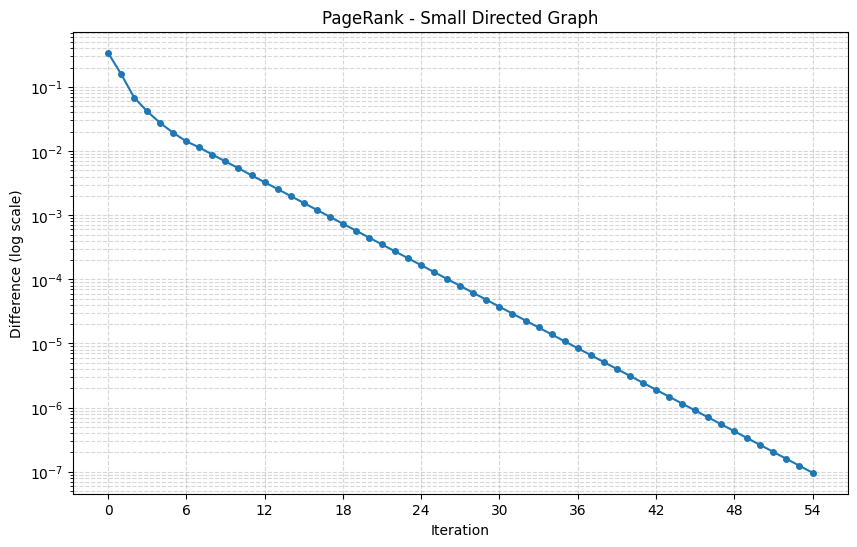

PageRank converged after 10 iterations
Rank differences: [0.14026842273149406, 0.024083857933484783, 0.004597813093863794, 0.0008093131928457713, 0.00015116196738272983, 2.479165150677705e-05, 4.327263512305876e-06, 7.5232852281195e-07, 1.2528196778778533e-07, 2.3195577135252943e-08]


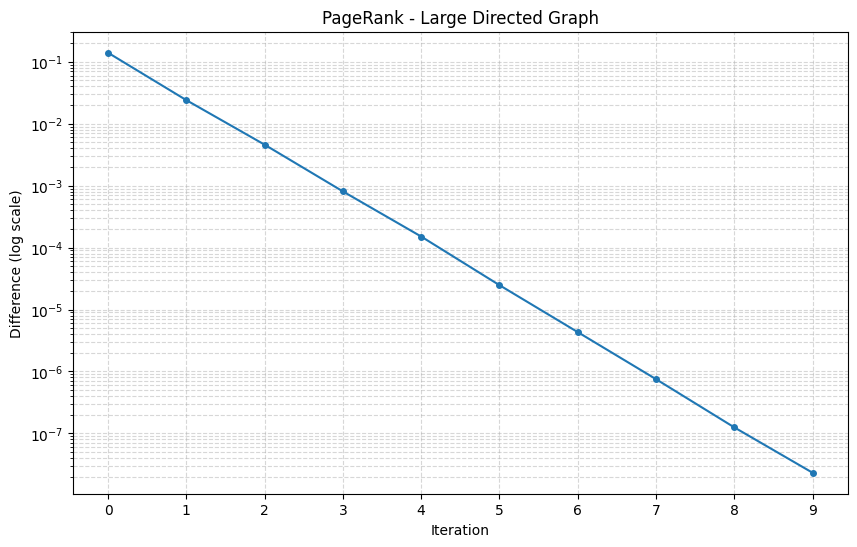

In [20]:
def run_pagerank(G: DiGraph, max_iter=10000, tol=1e-7):
    """
    Run PageRank algorithm and track convergence.

    Parameters:
    - G: NetworkX directed graph
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance

    Returns:
    - ranks_history: List of PageRank dictionaries for each iteration
    - diffs: List of differences between consecutive iterations
    """
    n = G.number_of_nodes()
    ranks_history = []

    # Initialize ranks
    ranks = {node: 1.0/n for node in G.nodes()}
    ranks_history.append(ranks.copy())

    alpha = 0.85  # Damping parameter
    diffs = []

    for i in range(max_iter):
        new_ranks = {node: (1-alpha)/n for node in G.nodes()}

        # Update ranks
        for node in G.nodes():
            for neighbor in G.predecessors(node):
                new_ranks[node] += alpha * ranks[neighbor] / max(1, G.out_degree(neighbor))

        # Calculate difference for convergence check
        diff = sum(abs(new_ranks[node] - ranks[node]) for node in G.nodes())
        diffs.append(diff)

        ranks = new_ranks.copy()
        ranks_history.append(ranks.copy())

        if diff < tol:
            print(f"PageRank converged after {i+1} iterations")
            print(f"Rank differences: {diffs}")
            return ranks_history, diffs

    print(f"PageRank did not converge after {max_iter} iterations")
    print(f"Rank differences: {diffs}")
    return ranks_history, diffs

def plot_pagerank_convergence(diffs, title):
    """
    Plots the convergence of an algorithm.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(diffs, marker='o', markersize=4)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Difference (log scale)")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

small_graph = generate_graph(nodes=15, p=0.2)
_, small_diffs = run_pagerank(small_graph)
plot_pagerank_convergence(small_diffs, "PageRank - Small Directed Graph")

large_graph = generate_graph(nodes=100)  # Using a moderate size for demonstration
_, large_diffs = run_pagerank(large_graph)
plot_pagerank_convergence(large_diffs, "PageRank - Large Directed Graph")

## HITS
Run HITS on small/large graphs and plot the convergences of their hub/authority values.

HITS converged after 28 iterations
Authority score differences: [0.3666666666666668, 0.13603603603603603, 0.04855350694463042, 0.01900222346853918, 0.007611053580390684, 0.0031169708328893948, 0.0014275108966937755, 0.0007233789477807551, 0.0003983816253961669, 0.00023398559411058444, 0.000140670055063373, 8.864197151647532e-05, 5.799304093042756e-05, 3.786505007441227e-05, 2.4703233690830627e-05, 1.6113813457950196e-05, 1.0512542306741895e-05, 6.86024400579216e-06, 4.47826084952474e-06, 2.9242319525982566e-06, 1.9099943395486582e-06, 1.2478212185161597e-06, 8.1537068694678e-07, 5.328738528530622e-07, 3.4829459707747673e-07, 2.2767262592131993e-07, 1.4883583831972608e-07, 9.730374405606673e-08]
Hub score differences: [0.4489583333333334, 0.079880617977528, 0.03037989944734839, 0.01184589049275853, 0.004811982798978511, 0.0021255243105867544, 0.001012033426017682, 0.0005148111322090532, 0.0002835954807458574, 0.00016539259289250624, 0.000106545009322348, 7.098676267446036e-05, 4.7100978

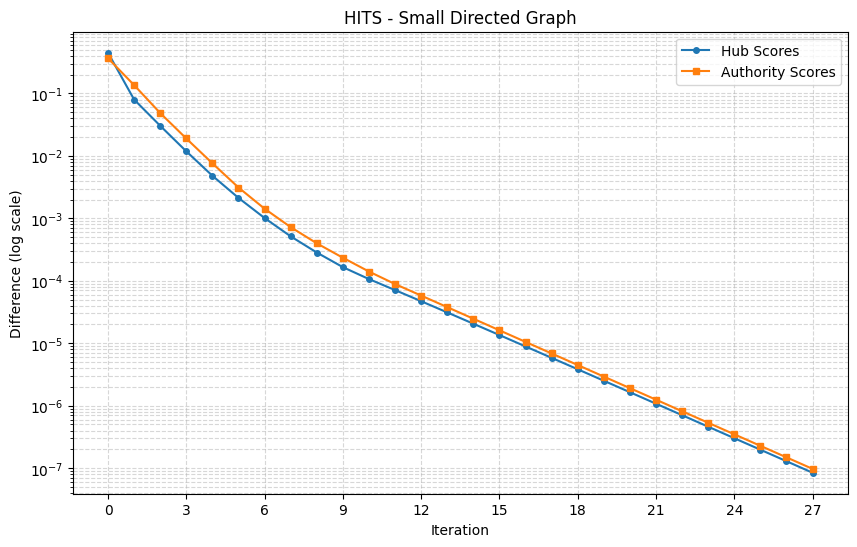

HITS converged after 8 iterations
Authority score differences: [0.16079601990049766, 0.02984383409017917, 0.0021153965375483776, 0.00020800453174439886, 2.2897275753372415e-05, 2.7215820702138765e-06, 3.362672082608126e-07, 4.2533649595444256e-08]
Hub score differences: [0.14815167682926836, 0.007546135984105382, 0.0006530190213583946, 6.898414905080578e-05, 7.840798332285973e-06, 9.336450285200165e-07, 1.1516486510612656e-07, 1.4549640834152222e-08]


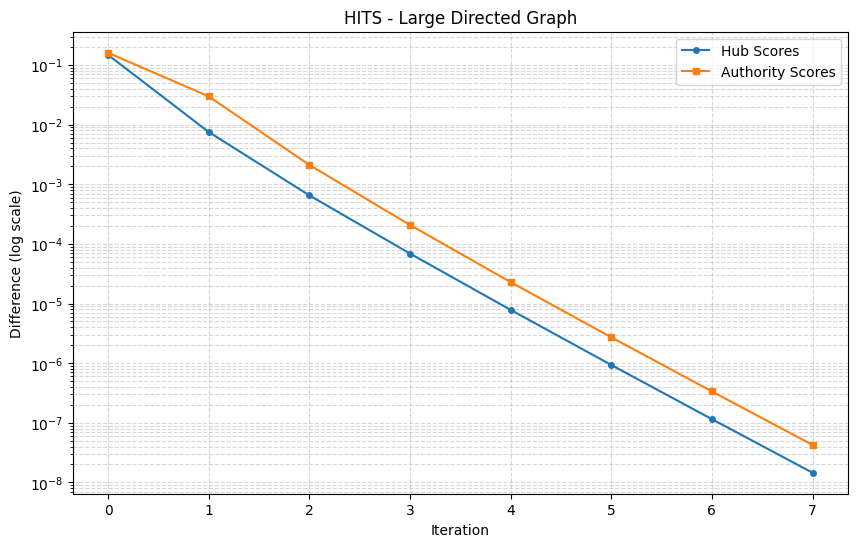

In [45]:
def run_hits(G, max_iter=100, tol=1e-7):
    """
    Run HITS algorithm and track convergence.
    """
    n = G.number_of_nodes()

    # Initialize hub and authority scores
    hub = {node: 1.0/n for node in G.nodes()}
    auth = {node: 1.0/n for node in G.nodes()}

    hub_diffs = []
    auth_diffs = []

    for i in range(max_iter):
        # Update authority scores
        new_auth = {node: 0.0 for node in G.nodes()}
        for node in G.nodes():
            for neighbor in G.predecessors(node):
                new_auth[node] += hub[neighbor]

        # Normalize authority scores
        auth_sum = sum(new_auth.values())
        if auth_sum > 0:
            new_auth = {node: score/auth_sum for node, score in new_auth.items()}

        # Update hub scores
        new_hub = {node: 0.0 for node in G.nodes()}
        for node in G.nodes():
            for neighbor in G.successors(node):
                new_hub[node] += new_auth[neighbor]

        # Normalize hub scores
        hub_sum = sum(new_hub.values())
        if hub_sum > 0:
            new_hub = {node: score/hub_sum for node, score in new_hub.items()}

        # Calculate differences for convergence
        hub_diff = sum(abs(new_hub[node] - hub[node]) for node in G.nodes())
        auth_diff = sum(abs(new_auth[node] - auth[node]) for node in G.nodes())

        hub_diffs.append(hub_diff)
        auth_diffs.append(auth_diff)

        hub = new_hub.copy()
        auth = new_auth.copy()

        if max(hub_diff, auth_diff) < tol:
            print(f"HITS converged after {i+1} iterations")
            print(f"Authority score differences: {auth_diffs}")
            print(f"Hub score differences: {hub_diffs}")
            return hub, auth, hub_diffs, auth_diffs

    print(f"HITS didn't converge after {max_iter} iterations")
    print(f"Authority score differences: {auth_diffs}")
    print(f"Hub score differences: {hub_diffs}")
    return hub, auth, hub_diffs, auth_diffs

def plot_hits_convergence(hub_diffs, auth_diffs, title):
    plt.figure(figsize=(10, 6))

    plt.plot(hub_diffs, marker='o', markersize=4, label='Hub Scores')
    plt.plot(auth_diffs, marker='s', markersize=4, label='Authority Scores')
    plt.legend()

    plt.yscale('log')
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Difference (log scale)")
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

small_graph = generate_graph(nodes=15, p=0.2)
_, _, hits_hub_diffs, hits_auth_diffs = run_hits(small_graph)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"HITS - Small Directed Graph")

large_graph = generate_graph(nodes=100)
_, _, hits_hub_diffs, hits_auth_diffs = run_hits(large_graph)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"HITS - Large Directed Graph")

## Randomized HITS
Implement randomized HITS using the formulas described in the paper (ie including teleportation), and plot its convergences.

HITS converged after 25 iterations
Authority score differences: [0.34390804597701163, 0.12501573133926436, 0.04111513097567937, 0.014990961606447282, 0.0056053771575549196, 0.002164697193763164, 0.0009317613586916642, 0.00044818995330409657, 0.0002320924259419147, 0.00012733955406202908, 7.138832546865802e-05, 4.250610912583455e-05, 2.575265119873901e-05, 1.5572903892060747e-05, 9.409628526307542e-06, 5.684414611110359e-06, 3.4342941325391473e-06, 2.0753173741653967e-06, 1.2544257467529685e-06, 7.584326267139757e-07, 4.5865871043911446e-07, 2.7742685676295994e-07, 1.6783360765569577e-07, 1.0154709308976204e-07, 6.144726495422442e-08]
Hub score differences: [0.4244877488452609, 0.06927022661550002, 0.02460367956267698, 0.008950769594549565, 0.0034258471464922377, 0.0014357431267312181, 0.0006428789171059827, 0.00030894154462709957, 0.00016048520421705487, 8.840039539273221e-05, 5.3484084767217895e-05, 3.2905547337855334e-05, 2.0174634761910976e-05, 1.2334606814152008e-05, 7.524489812207

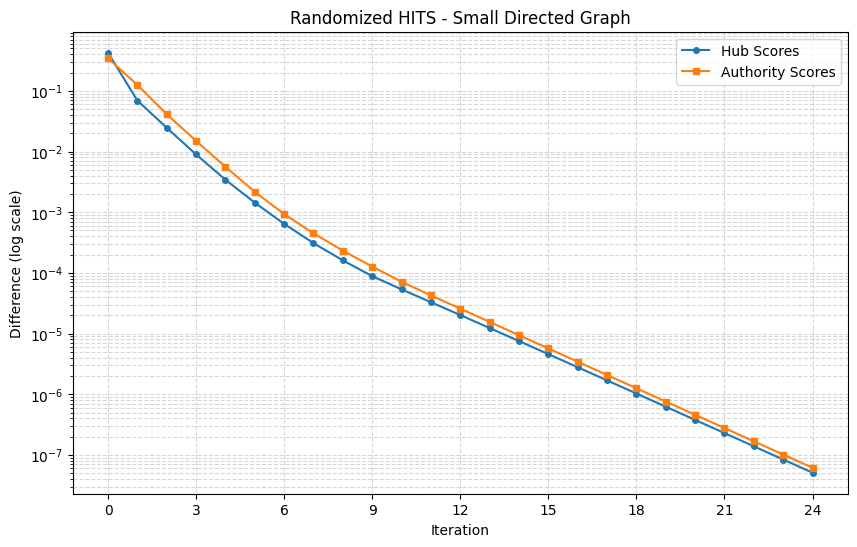

HITS converged after 8 iterations
Authority score differences: [0.1593965767333914, 0.029346247877345, 0.0020470292791415655, 0.00019807795116795653, 2.145646415498137e-05, 2.5096787555573333e-06, 3.0510706684576394e-07, 3.796846707437157e-08]
Hub score differences: [0.1468861756780937, 0.0073625124130160344, 0.0006269250573092602, 6.516958987897673e-05, 7.288836102891175e-06, 8.540176821836276e-07, 1.0364532360401107e-07, 1.2882873988082078e-08]


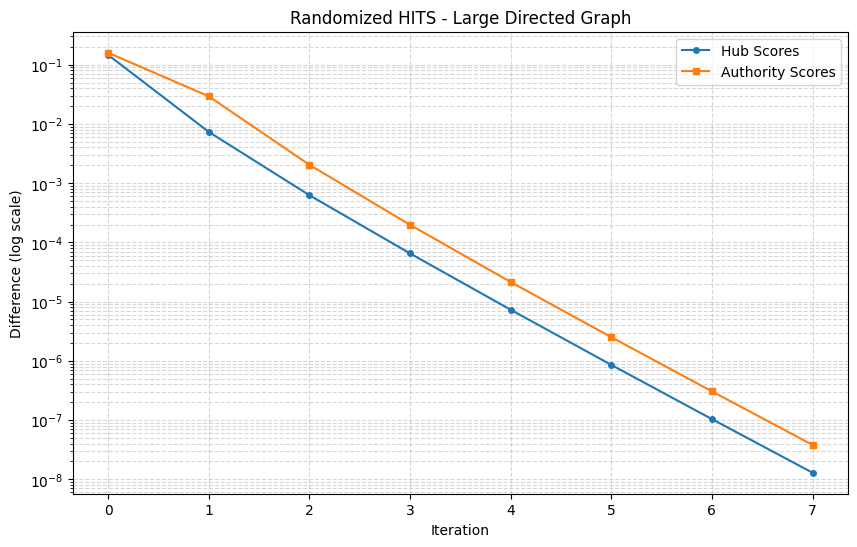

In [48]:
def run_randomized_hits(G: DiGraph, max_iter=100, tol=1e-7):
    """
    Run Randomized HITS algorithm and track convergence.
    """
    n = G.number_of_nodes()

    hub = {node: 1.0/n for node in G.nodes()}
    auth = {node: 1.0/n for node in G.nodes()}

    hub_diffs = []
    auth_diffs = []
    epsilon = 0.15  # Random jump probability

    for i in range(max_iter):
        # Update authority scores
        new_auth = {node: epsilon/n for node in G.nodes()}
        for node in G.nodes():
            # From backlinks
            incoming_score = 0
            for neighbor in G.predecessors(node):
                incoming_score += hub[neighbor]
            new_auth[node] += (1-epsilon) * incoming_score

        # Normalize authority scores
        auth_sum = sum(new_auth.values())
        if auth_sum > 0:
            new_auth = {node: score/auth_sum for node, score in new_auth.items()}

        # Update hub scores
        new_hub = {node: epsilon/n for node in G.nodes()}
        for node in G.nodes():
            # From forward links
            outgoing_score = 0
            for neighbor in G.successors(node):
                outgoing_score += new_auth[neighbor]
            new_hub[node] += (1-epsilon) * outgoing_score

        # Normalize hub scores
        hub_sum = sum(new_hub.values())
        if hub_sum > 0:
            new_hub = {node: score/hub_sum for node, score in new_hub.items()}

        # Calculate differences for convergence
        hub_diff = sum(abs(new_hub[node] - hub[node]) for node in G.nodes())
        auth_diff = sum(abs(new_auth[node] - auth[node]) for node in G.nodes())

        hub_diffs.append(hub_diff)
        auth_diffs.append(auth_diff)

        hub = new_hub.copy()
        auth = new_auth.copy()

        if max(hub_diff, auth_diff) < tol:
            print(f"HITS converged after {i+1} iterations")
            print(f"Authority score differences: {auth_diffs}")
            print(f"Hub score differences: {hub_diffs}")
            return hub, auth, hub_diffs, auth_diffs

    print(f"HITS didn't converge after {max_iter} iterations")
    print(f"Authority score differences: {auth_diffs}")
    print(f"Hub score differences: {hub_diffs}")
    return hub, auth, hub_diffs, auth_diffs

small_graph = generate_graph(nodes=15, p=0.2)
_, _, hits_hub_diffs, hits_auth_diffs = run_randomized_hits(small_graph)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"Randomized HITS - Small Directed Graph")

large_graph = generate_graph(nodes=100)
_, _, hits_hub_diffs, hits_auth_diffs = run_randomized_hits(large_graph)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"Randomized HITS - Large Directed Graph")

## Subspace HITS

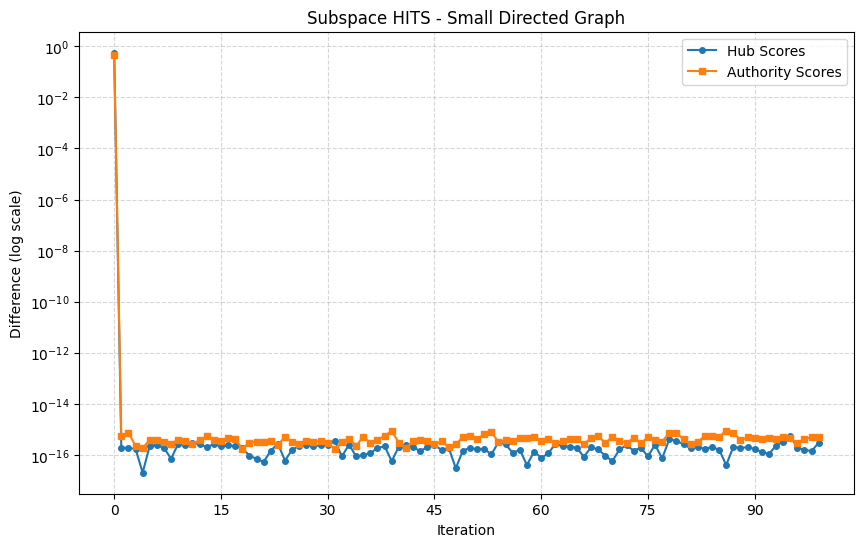

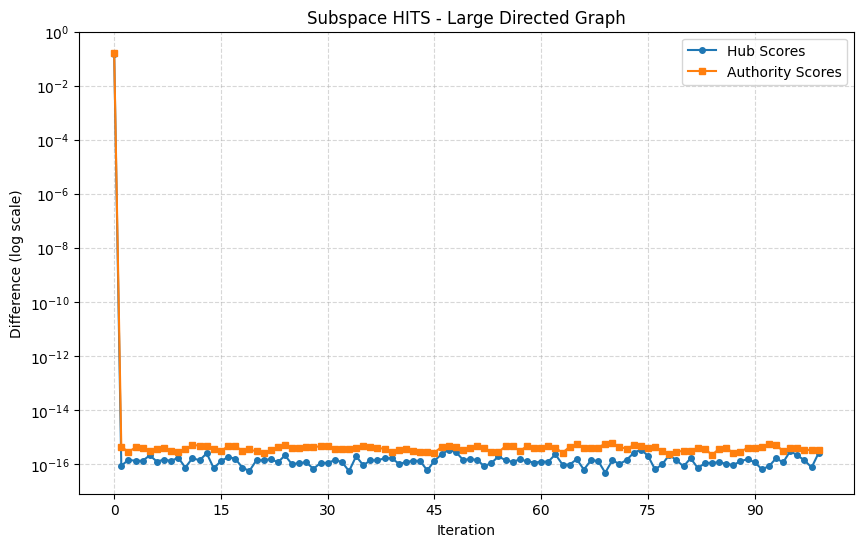

In [84]:
from scipy.sparse.linalg import svds

def run_subspace_hits(G, k=4, max_iter=100, tol=1e-10):
    """
    Subspace HITS algorithm with top-k eigenvectors.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    index = {node: i for i, node in enumerate(nodes)}
    reverse_index = {i: node for node, i in index.items()}

    # Build graph matrix for easier manipulation
    A = np.zeros((n, n))
    for i in G.nodes():
        for j in G.successors(i):
            A[index[i], index[j]] = 1.0

    # Get required matrices
    AAT = A @ A.T
    ATA = A.T @ A

    prev_hub = np.ones(n) / n
    prev_auth = np.ones(n) / n

    hub_diffs = []
    auth_diffs = []

    for i in range(max_iter):
        try:
            u_hub, _, _ = svds(AAT, k=k)
            _, _, v_auth = svds(ATA, k=k)
        except np.linalg.LinAlgError:
            raise RuntimeError("SVD did not converge")

        # Compute scores from subspaces (L2 norm over rows of top-k vectors)
        hub_vec = np.linalg.norm(u_hub, axis=1)
        auth_vec = np.linalg.norm(v_auth.T, axis=1)

        # Normalize
        hub_vec /= np.sum(hub_vec) or 1.0
        auth_vec /= np.sum(auth_vec) or 1.0

        # Convergence
        hub_diff = np.linalg.norm(hub_vec - prev_hub, ord=1)
        auth_diff = np.linalg.norm(auth_vec - prev_auth, ord=1)

        hub_diffs.append(hub_diff)
        auth_diffs.append(auth_diff)

        #if max(hub_diff, auth_diff) < tol:
            #print(f"Subspace HITS converged after {i+1} iterations")
            #break

        prev_hub = hub_vec.copy()
        prev_auth = auth_vec.copy()

    #else:
        #print(f"Subspace HITS didn't converge after {max_iter} iterations")

    hub_scores = {reverse_index[i]: hub_vec[i] for i in range(n)}
    auth_scores = {reverse_index[i]: auth_vec[i] for i in range(n)}
    return hub_scores, auth_scores, hub_diffs, auth_diffs

small_graph = generate_graph(nodes=15, p=0.2)
_, _, hits_hub_diffs, hits_auth_diffs = run_subspace_hits(small_graph, k=1)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"Subspace HITS - Small Directed Graph")

large_graph = generate_graph(nodes=100)
_, _, hits_hub_diffs, hits_auth_diffs = run_subspace_hits(large_graph, k=1)
plot_hits_convergence(hits_hub_diffs, hits_auth_diffs, f"Subspace HITS - Large Directed Graph")

### Comparison of values for HITS variants

HITS converged after 28 iterations
Authority score differences: [0.3666666666666668, 0.13603603603603603, 0.04855350694463042, 0.01900222346853918, 0.007611053580390684, 0.0031169708328893948, 0.0014275108966937755, 0.0007233789477807551, 0.0003983816253961669, 0.00023398559411058444, 0.000140670055063373, 8.864197151647532e-05, 5.799304093042756e-05, 3.786505007441227e-05, 2.4703233690830627e-05, 1.6113813457950196e-05, 1.0512542306741895e-05, 6.86024400579216e-06, 4.47826084952474e-06, 2.9242319525982566e-06, 1.9099943395486582e-06, 1.2478212185161597e-06, 8.1537068694678e-07, 5.328738528530622e-07, 3.4829459707747673e-07, 2.2767262592131993e-07, 1.4883583831972608e-07, 9.730374405606673e-08]
Hub score differences: [0.4489583333333334, 0.079880617977528, 0.03037989944734839, 0.01184589049275853, 0.004811982798978511, 0.0021255243105867544, 0.001012033426017682, 0.0005148111322090532, 0.0002835954807458574, 0.00016539259289250624, 0.000106545009322348, 7.098676267446036e-05, 4.7100978

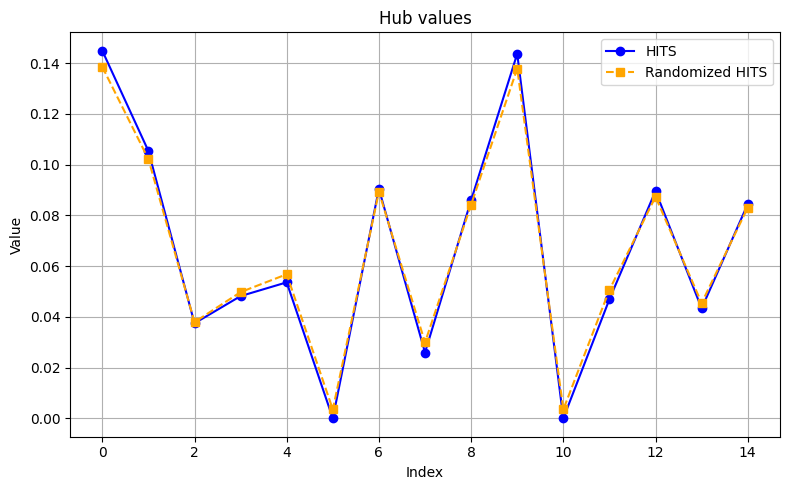

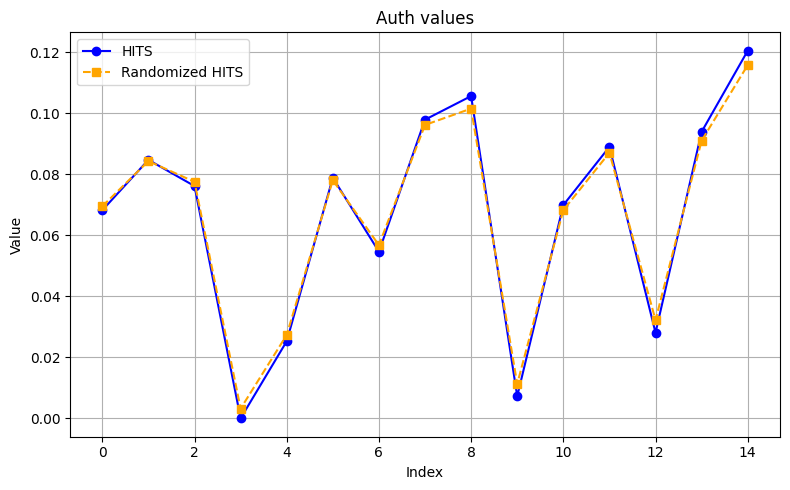

In [85]:
hits_hub, hits_auth, _, _ = run_hits(small_graph)
hits_r_hub, hits_r_auth, _, _ = run_randomized_hits(small_graph)
hits_s_hub, hits_s_auth, _, _ = run_subspace_hits(small_graph)

def plot_comparisons(y1, y2, y3=None,
                     labels=("Series 1", "Series 2", "Series 3"),
                     colors=("blue", "orange", "green"),
                     title="",
                     x_label="Index", y_label="Value"):
    plt.figure(figsize=(8, 5))

    x1 = range(len(y1))
    x2 = range(len(y2))


    plt.plot(x1, y1, marker='o', linestyle='-', color=colors[0], label=labels[0])
    plt.plot(x2, y2, marker='s', linestyle='--', color=colors[1], label=labels[1])


    if y3:
      x3 = range(len(y3))
      plt.plot(x2, y2, marker='o', linestyle='-', color=colors[2], label=labels[2])

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparisons(y1=hits_hub.values(), y2=hits_r_hub.values(), labels=("HITS", "Randomized HITS", "Subspace HITS"), title="Hub values")
plot_comparisons(y1=hits_auth.values(), y2=hits_r_auth.values(), labels=("HITS", "Randomized HITS", "Subspace HITS"), title="Auth values")

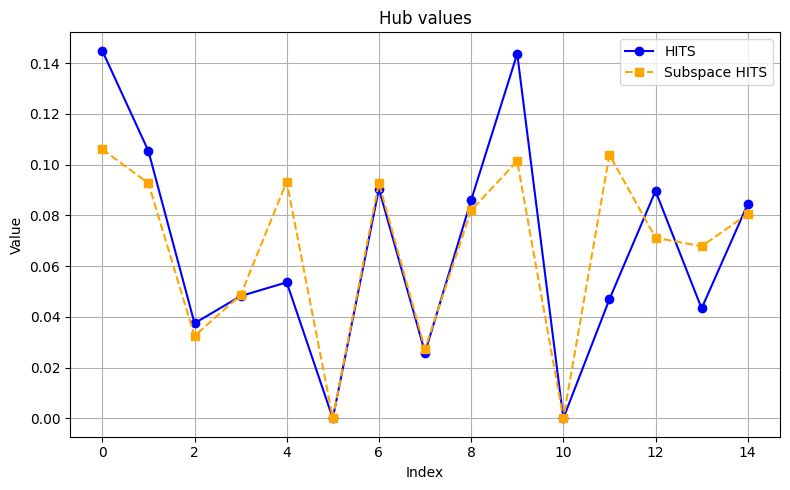

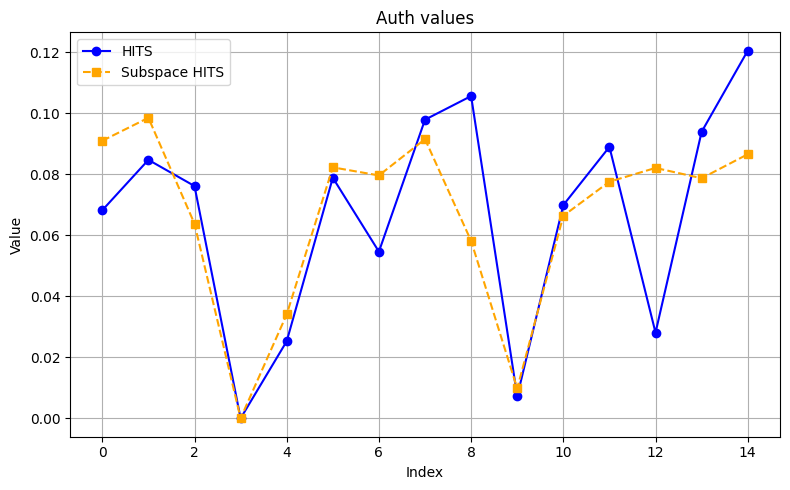

In [86]:
plot_comparisons(y1=hits_hub.values(), y2=hits_s_hub.values(), labels=("HITS", "Subspace HITS"), title="Hub values")
plot_comparisons(y1=hits_auth.values(), y2=hits_s_auth.values(), labels=("HITS", "Subspace HITS"), title="Auth values")

In [ ]:
#plot_comparisons(y1=hits_hub.values(), y2=hits_r_hub.values(), y3=hits_s_hub.values(), labels=("HITS", "Randomized HITS", "Subspace HITS"), title="Hub values")
#plot_comparisons(y1=hits_auth.values(), y2=hits_r_auth.values(), y3=hits_s_auth.values(), labels=("HITS", "Randomized HITS", "Subspace HITS"), title="Auth values")